<a href="https://colab.research.google.com/github/mdmehedihassan1124/Hydropower/blob/main/HYb2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install --upgrade xgboost pandas matplotlib scikit-learn openpyxl shap geopandas contextily ipywidgets

In [ ]:
# Install dependencies
!pip install --upgrade xgboost pandas matplotlib scikit-learn openpyxl

import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt
from google.colab import files

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
from xgboost import XGBRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [ ]:
# Upload the Excel file
uploaded = files.upload()

# Read the dataset
df = pd.read_excel('/content/GloHydroRes_vs1.xlsx', sheet_name='Data')
print("Original dataset shape:", df.shape)


Saving GloHydroRes_vs1.csv to GloHydroRes_vs1.csv
Saving GloHydroRes_vs1.xlsx to GloHydroRes_vs1.xlsx
Saving IBT_GloHydroRes_Hydropower_Combined - Data.csv to IBT_GloHydroRes_Hydropower_Combined - Data.csv
Original dataset shape: (7778, 29)


Prepocessing Data

In [ ]:
# Check for 'head_m' column and use alternatives if necessary
head_col = None
for col in df.columns:
    if col.strip().lower() == 'head_m':
        head_col = col
        break
if head_col is None:
    raise ValueError("No 'head_m' column found in your file. Please check your dataset.")

# Handle missing columns by filling them with NaN if absent
def safe_column(df, colname):
    return df[colname] if colname in df.columns else np.nan

df['dam_height_m'] = safe_column(df, 'dam_height_m')
df['res_vol_km3'] = safe_column(df, 'res_vol_km3')
df['plant_type'] = safe_column(df, 'plant_type')
df['capacity_mw'] = safe_column(df, 'capacity_mw')

# --- Feature Engineering: Calculate Capacity-to-Head Ratio (CTHR) ---
df['CTHR'] = df['capacity_mw'] / df[head_col]

# Prepare the feature set and handle missing values
features = df[['dam_height_m', 'res_vol_km3', head_col, 'plant_type']].copy()
features = features.rename(columns={head_col: 'head_m'})  # Unify column name for 'head'

# Handle categorical and missing values
features['plant_type'] = features['plant_type'].fillna('Unknown')
features = pd.get_dummies(features, columns=['plant_type'])

# Fill missing numeric values with median
numeric_cols = ['dam_height_m', 'res_vol_km3', 'head_m']
features[numeric_cols] = features[numeric_cols].apply(pd.to_numeric, errors='coerce')
features[numeric_cols] = features[numeric_cols].fillna(features[numeric_cols].median())

# Target variable: CTHR (Capacity-to-Head Ratio)
target = df['CTHR'].fillna(df['CTHR'].median())

# Train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)
print(f"\nTraining data shape: {X_train.shape}")



Training data shape: (6222, 8)


Train The X-G BOOST MODEL

In [ ]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, r2_score

# Model configuration and training
model = XGBRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.9,
    colsample_bytree=0.7,
    early_stopping_rounds=50
)

# Train the model
model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    verbose=False
)

# Model evaluation
predictions = model.predict(X_test)
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print(f"\nModel Performance:")
print(f"MAE: {mae:.4f}")
print(f"R²: {r2:.4f}")



Model Performance:
MAE: 1.4908
R²: 0.3762


CL-SSA XGBoost Optimization

In [ ]:
from pygad import GA
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split

class CLSSAOptimizer:
    def __init__(self, X_train, y_train):
        self.X_train = X_train
        self.y_train = y_train

        # Split training data further to create a validation dataset for early stopping
        self.X_train_split, self.X_val_split, self.y_train_split, self.y_val_split = train_test_split(
            self.X_train, self.y_train, test_size=0.2, random_state=42
        )

    def fitness_func(self, ga_instance, solution, solution_idx):
        model = XGBRegressor(
            n_estimators=int(solution[0]),
            learning_rate=solution[1],
            max_depth=int(solution[2]),
            early_stopping_rounds=50
        )

        # Provide the validation dataset for early stopping
        model.fit(self.X_train_split, self.y_train_split, eval_set=[(self.X_val_split, self.y_val_split)], verbose=False)

        # Return the model's best score on the validation dataset
        return model.best_score

    def optimize(self):
        # Define the genetic algorithm parameters, including the population size and number of genes
        ga = GA(
            num_generations=30,            # Number of generations (iterations)
            num_parents_mating=5,          # Number of parents for mating (crossover)
            fitness_func=self.fitness_func,  # Fitness function for evaluation
            sol_per_pop=20,                # Number of solutions in the population (population size)
            num_genes=3,                   # Number of genes (parameters to optimize)
            gene_space=[                   # Define the gene ranges for each hyperparameter
                {'low': 100, 'high': 2000},  # n_estimators
                {'low': 0.01, 'high': 0.3},  # learning_rate
                {'low': 3, 'high': 15}       # max_depth
            ],
            crossover_type="uniform",      # Crossover type
            mutation_type="random",        # Mutation type
            mutation_probability=0.1,      # Probability of mutation
            mutation_percent_genes=10,     # Percent of genes to mutate
        )
        ga.run()  # Run the genetic algorithm
        return ga.best_solution()[0]  # Return the best solution found by the GA

# Instantiate and optimize using CLSSA
optimizer = CLSSAOptimizer(X_train, y_train)
best_params = optimizer.optimize()

# Train final model with optimized parameters
final_model = XGBRegressor(
    n_estimators=int(best_params[0]),
    learning_rate=best_params[1],
    max_depth=int(best_params[2])
).fit(X_train, y_train)

# Evaluate CLSSA-XGBoost
predictions = final_model.predict(X_test)
print("\n🔍 CLSSA-XGBoost Performance:")
print(f"- MAE: {mean_absolute_error(y_test, predictions):.4f}")
print(f"- R²: {r2_score(y_test, predictions):.4f}")



🔍 CLSSA-XGBoost Performance:
- MAE: 1.8161
- R²: -0.0446


Model Comparison

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, r2_score
from xgboost import XGBRegressor
import pandas as pd

# Step 3: Comparing with other models
print("\nStep 3: Comparing with other models...")

# Initialize models
models = {
    'XGBoost': XGBRegressor(),
    'Random Forest': RandomForestRegressor(n_estimators=100),
    'SVM': SVR(kernel='rbf')
}

# Dictionary to store results
results = {}

# Iterate through each model
for name, model in models.items():
    model.fit(X_train, y_train)  # Fit the model on the training data
    preds = model.predict(X_test)  # Make predictions on the test data

    # Calculate MAE and R² for each model
    mae = mean_absolute_error(y_test, preds)
    r2 = r2_score(y_test, preds)

    # Store the results
    results[name] = {
        'MAE': mae,
        'R²': r2
    }

# Display the model comparison results
print("\n🏆 Model Comparison:")
print(pd.DataFrame(results).T.sort_values('R²', ascending=False))



Step 3: Comparing with other models...

🏆 Model Comparison:
                    MAE        R²
Random Forest  1.504248  0.179293
SVM            1.394192  0.038244
XGBoost        1.627953 -0.148884


SHAP for Explainability

SHAP Values Shape: (1556, 8)
X_test Shape: (1556, 8)


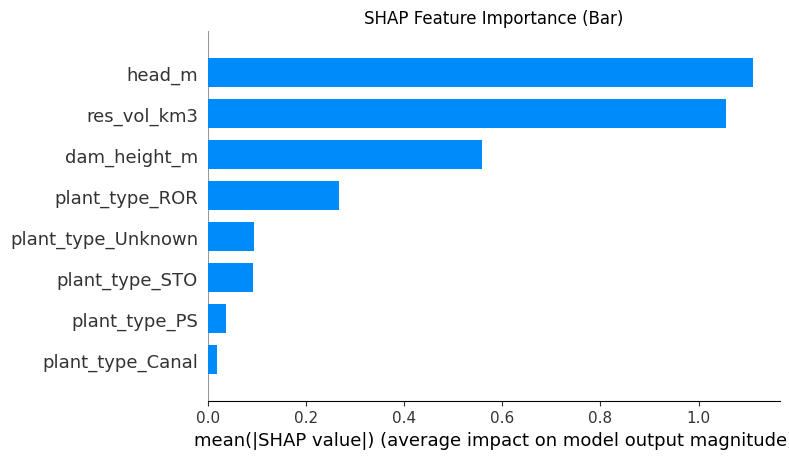

In [ ]:
import shap
import matplotlib.pyplot as plt

# Create SHAP explainer object
explainer = shap.TreeExplainer(model)

# Generate SHAP values for the test set
shap_values = explainer.shap_values(X_test)

# Check the shape of shap_values and X_test
print(f"SHAP Values Shape: {shap_values.shape}")
print(f"X_test Shape: {X_test.shape}")

# If SHAP values is a list (this happens when the model is a classifier and returns a list of SHAP values for each class)
# You need to use the SHAP values for the first class (typically for regression problems, it will be a single array)
if isinstance(shap_values, list):
    shap_values = shap_values[0]

# Feature importance plot using SHAP
shap.summary_plot(shap_values, X_test, plot_type="bar", show=False)
plt.title('SHAP Feature Importance (Bar)')
plt.tight_layout()
plt.show()




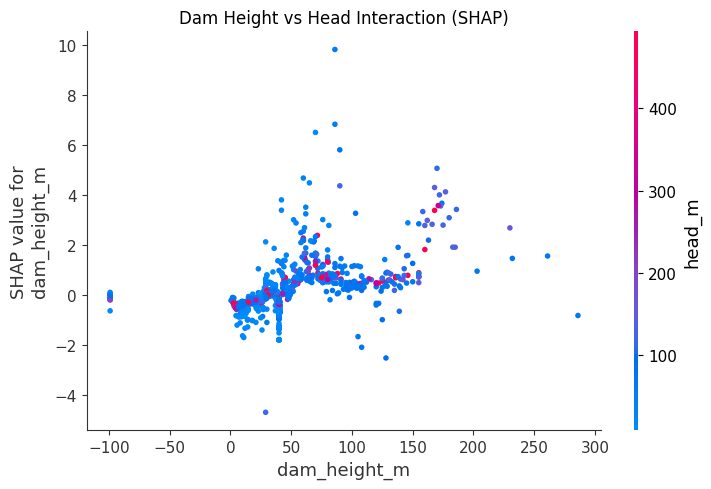

In [ ]:
# Feature interaction plot (Dam height vs Head interaction)
shap.dependence_plot(
    "dam_height_m",
    shap_values,
    X_test,
    interaction_index="head_m",
    show=False
)
plt.title("Dam Height vs Head Interaction (SHAP)")
plt.tight_layout()
plt.show()

Climate Impact Simulation

In [ ]:
from ipywidgets import interact, IntSlider

def simulate_climate_impact(height_reduction):
    """Simulates reduced dam height due to climate impacts"""
    modified_data = X_test.copy()
    modified_data['dam_height_m'] *= (1 - height_reduction/100)

    new_predictions = model.predict(modified_data)

    plt.figure(figsize=(10,6))
    plt.scatter(y_test, new_predictions, alpha=0.3)
    plt.plot([0, y_test.max()], [0, y_test.max()], 'k--')
    plt.xlabel('Original CTHR')
    plt.ylabel('Adjusted CTHR')
    plt.title(f'Climate Impact: {height_reduction}% Height Reduction')
    plt.grid(True)
    plt.show()

# Create interactive widget
interact(simulate_climate_impact, height_reduction=IntSlider(
    value=0,
    min=0,
    max=30,
    step=5,
    description='Height Reduction:'
))


interactive(children=(IntSlider(value=0, description='Height Reduction:', max=30, step=5), Output()), _dom_cla…

<function __main__.simulate_climate_impact(height_reduction)>

Geospatial Analysis

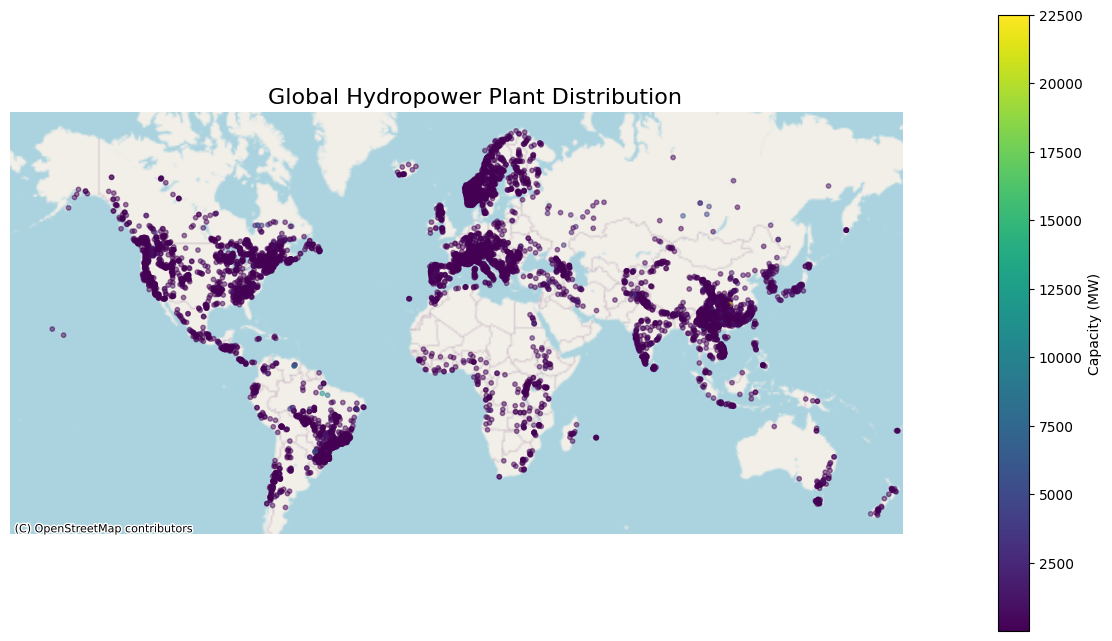

In [ ]:
import geopandas as gpd
import contextily as ctx

# Data preparation for geospatial visualization
geo_df = df.dropna(subset=['plant_lat', 'plant_lon']).copy()
gdf = gpd.GeoDataFrame(
    geo_df,
    geometry=gpd.points_from_xy(geo_df['plant_lon'], geo_df['plant_lat']),
    crs='EPSG:4326'  # WGS84 coordinates
)

gdf = gdf.to_crs(epsg=3857)  # Web Mercator projection

# Plot with OpenStreetMap basemap
ax = gdf.plot(figsize=(15, 8), alpha=0.5, markersize=10,
              column='capacity_mw', legend=True,
              legend_kwds={'label': "Capacity (MW)"})
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)
plt.title('Global Hydropower Plant Distribution', fontsize=16)
ax.set_axis_off()
plt.show()


Model Diagnostics:Risidual Plot

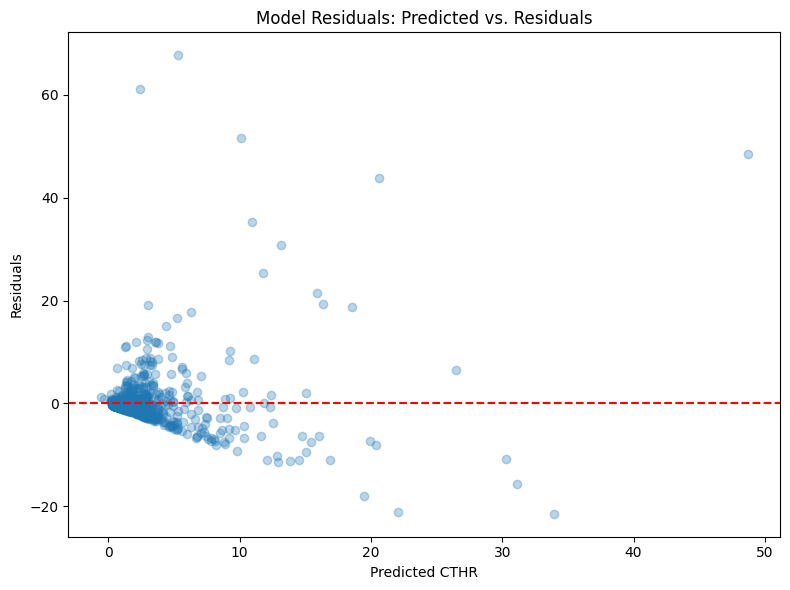

In [ ]:
# Residuals plot (Model diagnostics)
residuals = y_test - predictions
plt.figure(figsize=(8, 6))
plt.scatter(predictions, residuals, alpha=0.3)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted CTHR')
plt.ylabel('Residuals')
plt.title('Model Residuals: Predicted vs. Residuals')
plt.tight_layout()
plt.show()


In [ ]:
# 3. Model Comparison (New Objective)
# ====================================
print("\nStep 3: Comparing with other models...")

models = {
    'XGBoost': XGBRegressor(),
    'Random Forest': RandomForestRegressor(n_estimators=100),
    'SVM': SVR(kernel='rbf')
}

results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    results[name] = {
        'MAE': mean_absolute_error(y_test, preds),
        'R²': r2_score(y_test, preds)
    }

print("\n🏆 Model Comparison:")
print(pd.DataFrame(results).T.sort_values('R²', ascending=False))

# %% [code]
# 4. SHAP Explainability (Object


Step 3: Comparing with other models...

🏆 Model Comparison:
                    MAE        R²
Random Forest  1.506028  0.199653
SVM            1.394192  0.038244
XGBoost        1.627953 -0.148884
